In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

2023-09-30 21:00:53.148162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 4s 0us/step


In [3]:
train_images = train_images / 255.0
test_images = test_images / 255.0

from keras.utils import to_categorical

# One-hot encode labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [4]:
print('training inputs:', train_images.shape)
print('training labels:',train_labels.shape)
print('testing  inputs:',test_images.shape)
print('testing  labels:',test_labels.shape)

training inputs: (60000, 28, 28)
training labels: (60000, 10)
testing  inputs: (10000, 28, 28)
testing  labels: (10000, 10)


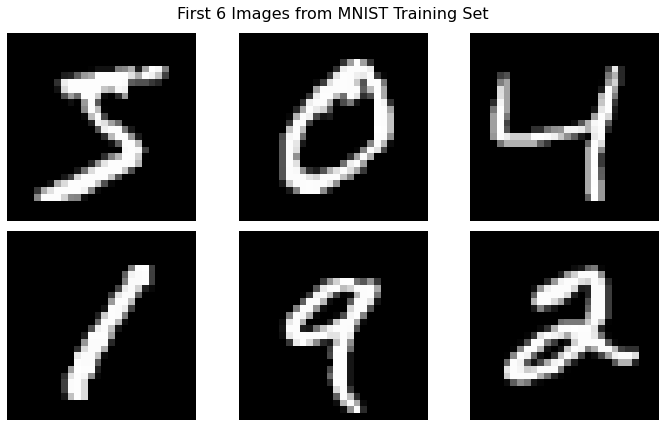

In [5]:
# Define the number of images to visualize
num_images = 6

# Create a figure and axes for subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))  # 2 rows, 3 columns for 6 images

# Plot the first 6 images
for i in range(num_images):
    row = i // 3  # Determine the row index
    col = i % 3   # Determine the column index
    axs[row, col].imshow(train_images[i], cmap='gray')  # Use grayscale colormap
    axs[row, col].axis('off')  # Turn off axis labels and ticks

# Set a title for the entire figure
fig.suptitle('First 6 Images from MNIST Training Set', fontsize=16)

# Adjust subplot spacing
plt.tight_layout(pad=1.0)

# Show the plot
plt.show()

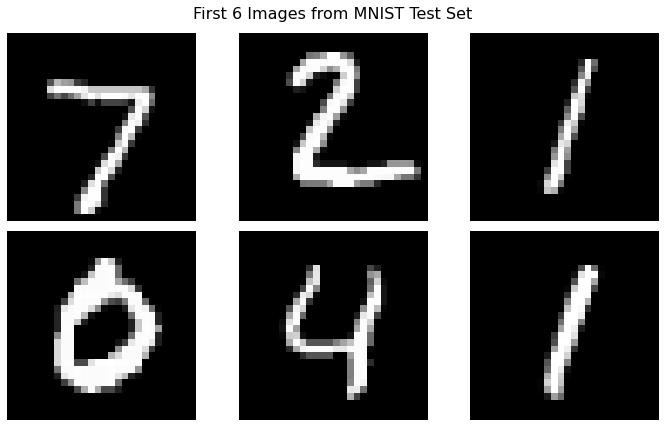

In [6]:
import matplotlib.pyplot as plt

# Define the number of images to visualize
num_images = 6

# Create a figure and axes for subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))  # 3x3 grid for 9 images

# Plot the first 9 test images
for i in range(num_images):
    row = i // 3  # Determine the row index
    col = i % 3   # Determine the column index
    axs[row, col].imshow(test_images[i], cmap='gray')  # Use grayscale colormap
    axs[row, col].axis('off')  # Turn off axis labels and ticks

# Set a title for the entire figure
fig.suptitle('First 6 Images from MNIST Test Set', fontsize=16)

# Adjust subplot spacing
plt.tight_layout(pad=1.0)

# Show the plot
plt.show()


In [7]:
class CustomDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation):
        super(CustomDenseLayer, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        # Initialize weights with a different name
        self.custom_weights = self.add_weight("custom_weights", shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.biases = self.add_weight("biases", shape=(self.units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        # Perform matrix multiplication and apply activation function
        output = tf.matmul(inputs, self.custom_weights) + self.biases
        if self.activation is not None:
            output = self.activation(output)
        return output

In [8]:
# Define the neural network model
model = keras.Sequential([
    # Input layer with input shape for MNIST images (28x28)
    keras.layers.Flatten(input_shape=(28, 28)),

    # Custom dense layer with 128 units and ReLU activation
    CustomDenseLayer(units=128, activation=tf.nn.relu),

    # Custom dense layer with 10 units and softmax activation (output layer)
    CustomDenseLayer(units=10, activation=tf.nn.softmax)
])

2023-09-30 21:05:51.754907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
def custom_sparse_categorical_crossentropy(y_true, y_pred):
    # Calculate the negative log probabilities
    neg_log_probs = -tf.math.log(tf.reduce_sum(y_true * y_pred, axis=1))

    # Compute the mean loss across the batch
    mean_loss = tf.reduce_mean(neg_log_probs)

    return mean_loss


In [10]:
def custom_accuracy(y_true, y_pred):
    # Calculate the index of the maximum predicted probability
    y_pred_max = tf.argmax(y_pred, axis=1)
    # Calculate the index of the true class (assuming one-hot encoding)
    y_true_max = tf.argmax(y_true, axis=1)
    # Compare the predicted and true class indices to determine accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true_max, y_pred_max), tf.float32))
    return accuracy

In [11]:
model.compile(optimizer='adam',
              loss=custom_sparse_categorical_crossentropy,
              metrics=[custom_accuracy])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 custom_dense_layer (CustomD  (None, 128)              100480    
 enseLayer)                                                      
                                                                 
 custom_dense_layer_1 (Custo  (None, 10)               1290      
 mDenseLayer)                                                    
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
750/750 [==============================] - 4s 4ms/step - loss: 0.3767 - custom_accuracy: 0.8991 - val_loss: 0.1955 - val_custom_accuracy: 0.9457
Epoch 2/10
750/750 [==============================] - 3s 3ms/step - loss: 0.1689 - custom_accuracy: 0.9511 - val_loss: 0.1472 - val_custom_accuracy: 0.9560
Epoch 3/10
750/750 [==============================] - 2s 3ms/step - loss: 0.1180 - custom_accuracy: 0.9658 - val_loss: 0.1170 - val_custom_accuracy: 0.9663
Epoch 4/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0893 - custom_accuracy: 0.9745 - val_loss: 0.1082 - val_custom_accuracy: 0.9678
Epoch 5/10
750/750 [==============================] - 3s 3ms/step - loss: 0.0713 - custom_accuracy: 0.9791 - val_loss: 0.0964 - val_custom_accuracy: 0.9705
Epoch 6/10
750/750 [==============================] - 3s 4ms/step - loss: 0.0581 - custom_accuracy: 0.9831 - val_loss: 0.0989 - val_custom_accuracy: 0.9698
Epoch 7/10
750/750 [==============================] - 3s 4ms/ste

In [14]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

313/313 [==============================] - 1s 2ms/step - loss: 0.0711 - custom_accuracy: 0.9791
Test accuracy: 97.91%


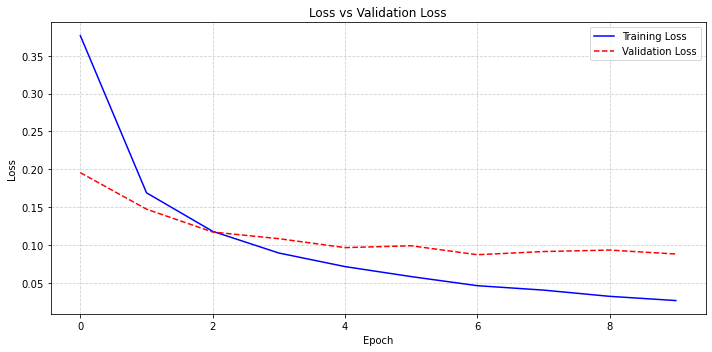

In [15]:
plt.figure(figsize=(10, 5))
plt.grid(True, linestyle='--', alpha=0.6)  # Add a grid with dashed lines and transparency
plt.plot(history.history['loss'], color='blue', linestyle='-', label='Training Loss')  # Solid line for training loss
plt.plot(history.history['val_loss'], color='red', linestyle='--', label='Validation Loss')  # Dashed line for validation loss
plt.legend()
plt.title('Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

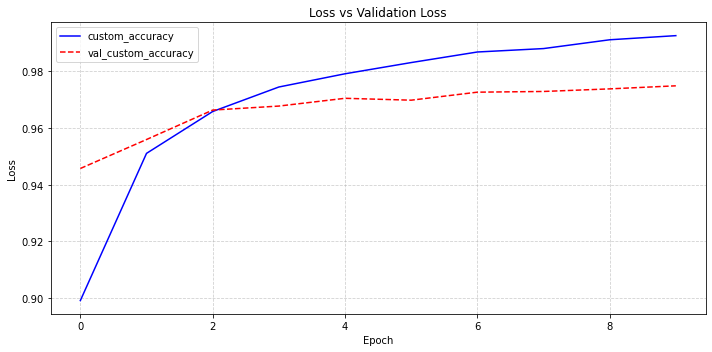

In [16]:
plt.figure(figsize=(10, 5))
plt.grid(True, linestyle='--', alpha=0.6)  # Add a grid with dashed lines and transparency
plt.plot(history.history['custom_accuracy'], color='blue', linestyle='-', label='custom_accuracy')  # Solid line for training loss
plt.plot(history.history['val_custom_accuracy'], color='red', linestyle='--', label='val_custom_accuracy')  # Dashed line for validation loss
plt.legend()
plt.title('Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [17]:
prediction = model.predict([test_images])


313/313 [==============================] - 1s 2ms/step


In [18]:
# prediction for single image

print('Probabilities: ', prediction[50])

print('Prediction: ', np.argmax(prediction[50]))

Probabilities:  [2.4272156e-05 5.2814562e-07 1.4949363e-05 6.6982165e-07 1.0013788e-06
 1.5838539e-05 9.9994266e-01 9.1305958e-09 9.7958527e-08 7.5350162e-09]


Prediction:  6


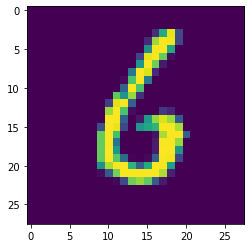

In [19]:
# visualize the image

plt.imshow(test_images[50])
plt.show()